In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import numpy as np
from os import listdir, getcwd
from os.path import isfile, join
import scipy.io.wavfile
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import figure as fig
from IPython.display import Audio
import seaborn as sns

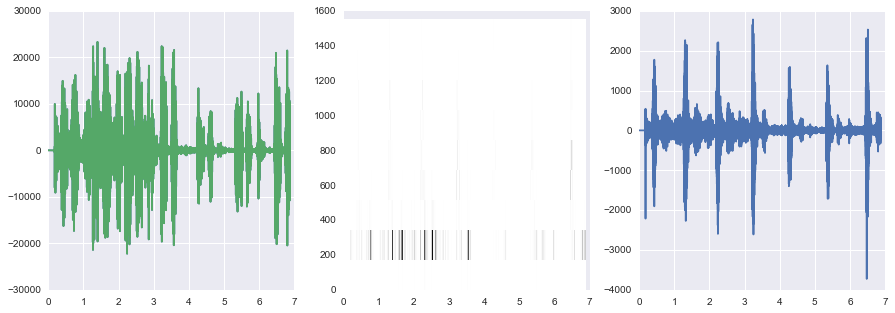

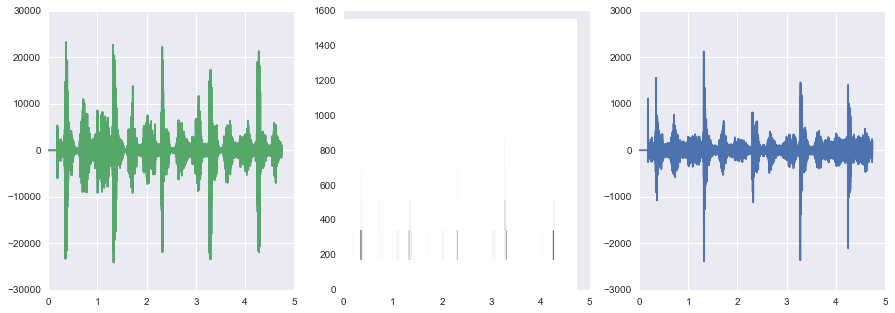

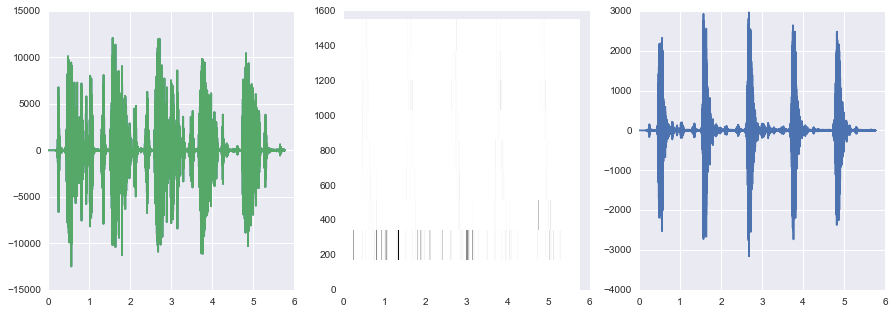

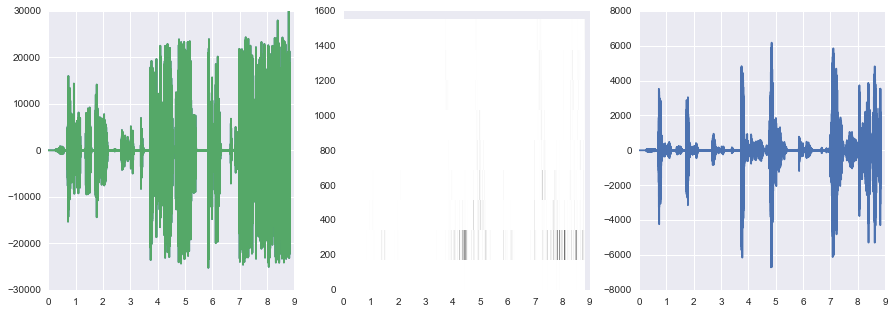

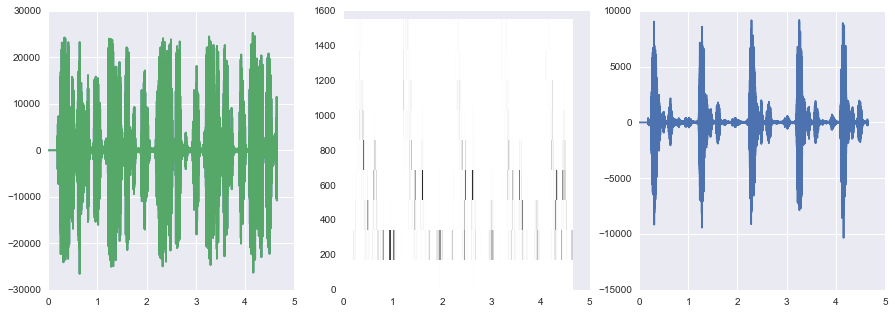

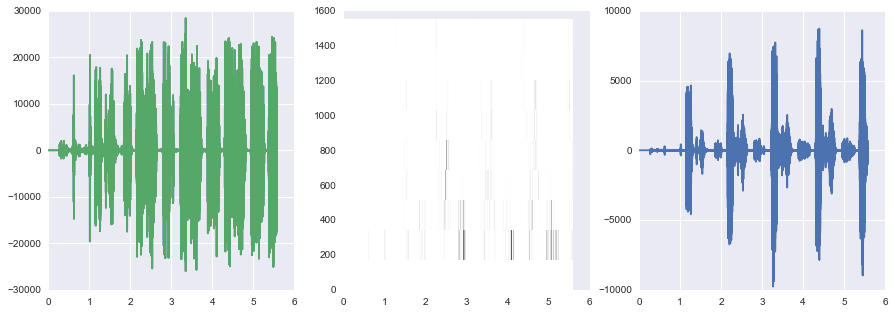

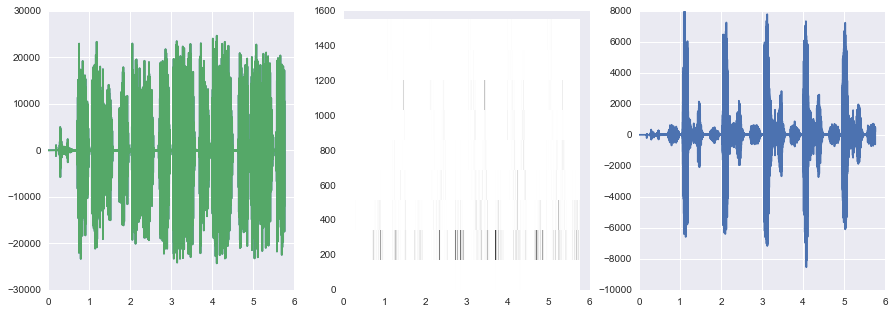

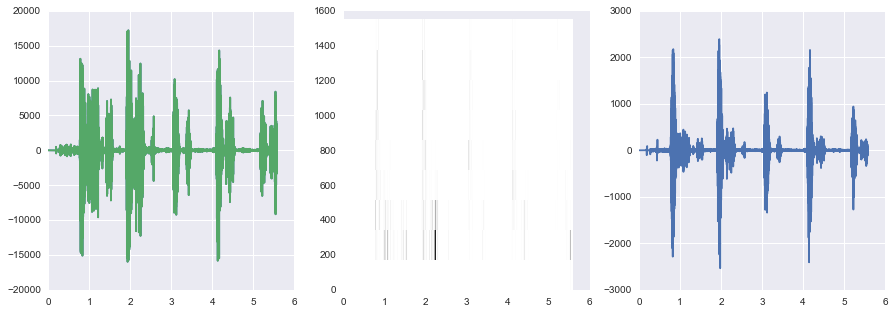

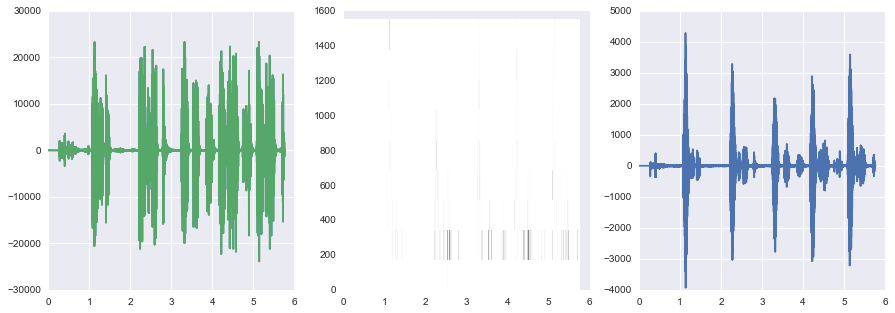

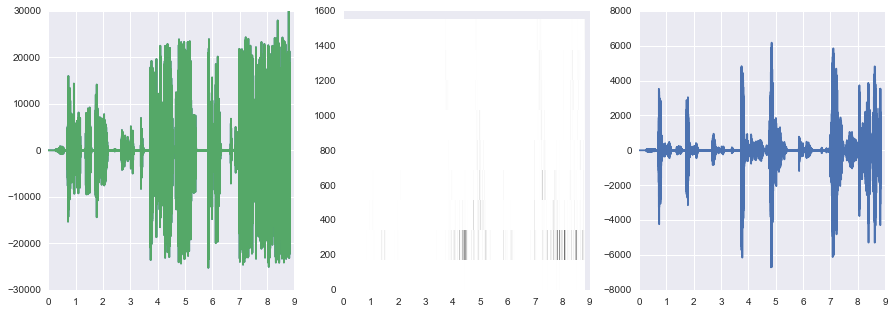

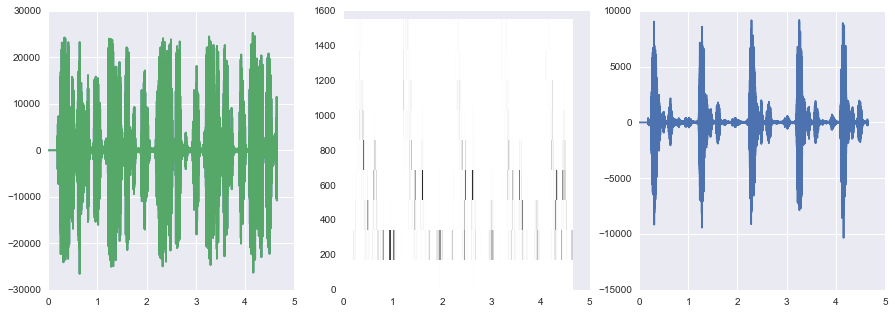

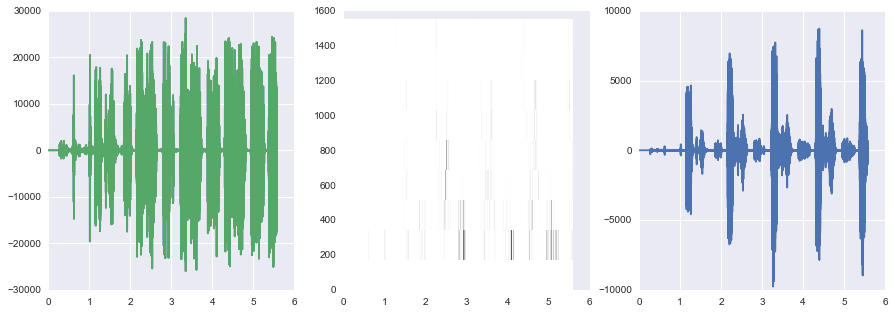

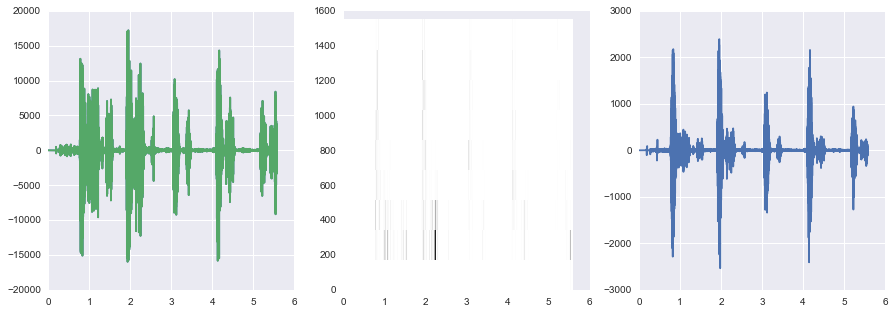

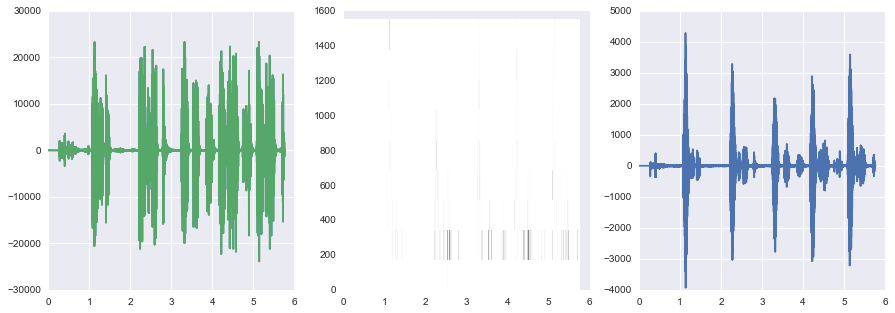

In [6]:
sampling_frequency = 44100
audio_dir = join(getcwd(),'..','vsu_tms_site','doppler_audio_samples')
training_wav_filenames = [f for f in listdir(audio_dir) if isfile(join(audio_dir,f)) and str(f)[-3:] not in 'txt']
training_wav_files = []

for f in training_wav_filenames:
    rate, wf = scipy.io.wavfile.read(join(audio_dir,f))
    training_wav_files.append(wf)
    xs = [i / float(sampling_frequency) for i in range(0, len(wf[:,0]))]
    f, axarr = plt.subplots(1,3,figsize=(15,5))
    axarr[0].plot(xs,wf)
    audio_out = wf[:,0]
    f, t, Sxx = signal.spectrogram(audio_out,fs=sampling_frequency)
    axarr[1].pcolormesh(t,f[:10],Sxx[:10,:])
    axarr[2].plot(xs,np.gradient(wf[:,0]))
    plt.show()
    Audio(audio_out,rate=44100)

1. Extract individual waveforms
    - use combination of amplitude and gradient to determine peak starts and segment
2. Calculate feature values for each waveform
3. Use feature values as predictors for the model

In [79]:
def find_waveform_start(wf):
    # Band-pass filtering
    nyq = 0.5 * 44100
    cutoff = 250 / nyq
    b, a = signal.butter(4,cutoff,'highpass')
    wf = signal.lfilter(b, a, wf)
    cutoff = 1000 / nyq
    b, a = signal.butter(4,cutoff,'lowpass')
    wf = signal.lfilter(b, a, wf)
    # Normalise waveform
    peak_amplitude = wf.max()
    wf = wf / float(peak_amplitude)
    # calculate magnitude
    wf_for_grad = [i if i > 0 else i*(-1) for i in wf]
    # Calculate gradients and normalise them
    wf_grad = np.gradient(wf_for_grad)
    peak_gradient = wf_grad.max()
    wf_grad = wf_grad / float(peak_gradient)
    # Waveform finding logic
    start_indices = []
    amplitude_threshold = 0.3
    gradient_threshold = 0.3
    running_lag = 0
    running_lag_threshold = 10000
    for i in range(0,len(wf)):
        if (wf[i] > amplitude_threshold and wf_grad[i] > gradient_threshold and running_lag >= running_lag_threshold):
            start_indices.append(1)
            running_lag = 0
        else:
            start_indices.append(0)
            running_lag += 1
    return wf, start_indices

In [82]:
Audio(training_wav_files[1][:,0],rate=44100)

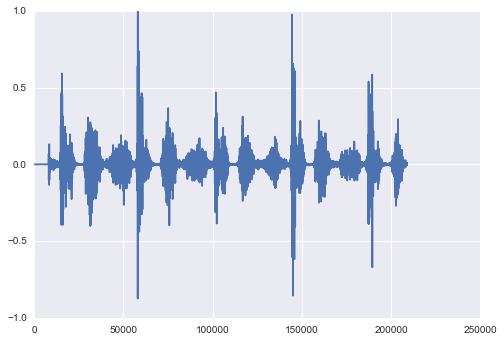

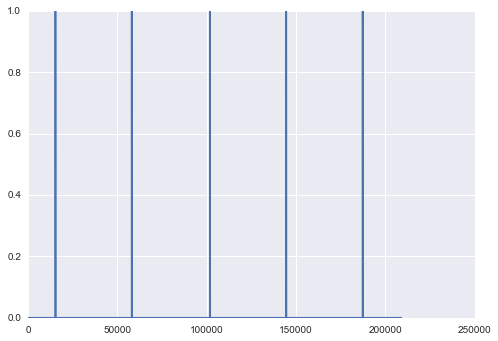

In [84]:
test_wf, start_indices = find_waveform_start(training_wav_files[1][:,0])
plt.plot(test_wf)
plt.show()
plt.plot(start_indices)
plt.show()
true_points = {}
for i in range(0,len(start_indices)):
    if (start_indices[i] is not 0):
        true_points[str(i)] = True
true_points
Audio(test_wf,rate=44100)